
**WISDM-51 Demo 3**

Sania Bandekar & Joao Lucas Veras

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ruhallahahmadian/wisdm-51")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/wisdm-51


In [ ]:
import pandas as pd
import glob
import os

# Get dataSetFilePath to all .csv files
dataSetFilePath = path + "/WISDM-51"

# Concat all .csv files into one
listCsvFiles =  glob.glob(os.path.join(dataSetFilePath, "*.csv"))
dataFrameList = [pd.read_csv(file) for file in listCsvFiles]
dataFrame = pd.concat(dataFrameList, ignore_index=True)

print(dataFrame.info())
print(dataFrame.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804403 entries, 0 to 4804402
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Subject-id      int64  
 1   Activity Label  object 
 2   Timestamp       int64  
 3   X-accel         float64
 4   Y-accel         float64
 5   Z-accel         float64
dtypes: float64(3), int64(2), object(1)
memory usage: 219.9+ MB
None
   Subject-id Activity Label        Timestamp   X-accel    Y-accel   Z-accel
0        1636              A  504627630476589 -4.471436 -11.006256 -0.353561
1        1636              A  504627680830592 -5.207367 -12.732834 -1.629135
2        1636              A  504627731184596 -5.844177 -11.135010 -2.733383
3        1636              A  504627781538600 -7.345474  -7.403900 -1.969910
4        1636              A  504627831892604 -8.717712  -5.766296  0.025681


In [ ]:
# Reduce data types of columns
for col in dataFrame.select_dtypes(include=["int64"]).columns:
    dataFrame[col] = dataFrame[col].astype("int32")

for col in dataFrame.select_dtypes(include=["float64"]).columns:
    dataFrame[col] = dataFrame[col].astype("float32")

for col in dataFrame.select_dtypes(include=["object"]).columns:  # Convert categorical data
    dataFrame[col] = dataFrame[col].astype("category")

print(dataFrame.info())
print(dataFrame.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804403 entries, 0 to 4804402
Data columns (total 6 columns):
 #   Column          Dtype   
---  ------          -----   
 0   Subject-id      int32   
 1   Activity Label  category
 2   Timestamp       int32   
 3   X-accel         float32 
 4   Y-accel         float32 
 5   Z-accel         float32 
dtypes: category(1), float32(3), int32(2)
memory usage: 96.2 MB
None
   Subject-id Activity Label  Timestamp   X-accel    Y-accel   Z-accel
0        1636              A -962032339 -4.471436 -11.006256 -0.353561
1        1636              A -911678336 -5.207367 -12.732834 -1.629135
2        1636              A -861324332 -5.844177 -11.135010 -2.733383
3        1636              A -810970328 -7.345474  -7.403900 -1.969910
4        1636              A -760616324 -8.717712  -5.766296  0.025681


Calculate Sampling Rate

In [ ]:
# Calculate average time difference between samples
dataFrame['Timestamp'] = dataFrame['Timestamp'].astype(float)
dataFrame = dataFrame.sort_values('Timestamp')
dataFrame['delta_time'] = dataFrame['Timestamp'].diff() / 1_000_000  # assuming microseconds
sampling_rate = 1 / dataFrame['delta_time'].mean()
print(f'Sampling rate: {sampling_rate} Hz')

Sampling rate: 1118.612968999182 Hz


Segment Data Into 3-Minute Windows

In [ ]:
# 3 minutes in seconds
window_seconds = 3 * 60

# Calculate number of samples per window
samples_per_window = int(sampling_rate * window_seconds)
# Total number of samples in dataset
num_samples = len(dataFrame)
# Number of full 3-minute windows
num_windows = num_samples // samples_per_window

print(f"Samples per window: {samples_per_window}")
print(f"Total samples: {num_samples}")
print(f"Number of full 3-minute windows: {num_windows}")

segments = []
for i in range(0, num_windows * samples_per_window, samples_per_window):  # 23 full windows
    segment = dataFrame.iloc[i:i + samples_per_window].copy()
    segments.append(segment)

print(f"Total 3-minute segments created: {len(segments)}")


Samples per window: 201350
Total samples: 4804403
Number of full 3-minute windows: 23
Total 3-minute segments created: 23


Extract Time Features

In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

def extract_time_features(segment):
    features = {}

    axes = ['X-accel', 'Y-accel', 'Z-accel']

    for axis in axes:
        data = segment[axis].values

        features[f'{axis}_mean'] = np.mean(data)
        features[f'{axis}_std'] = np.std(data)
        features[f'{axis}_var'] = np.var(data)
        features[f'{axis}_min'] = np.min(data)
        features[f'{axis}_max'] = np.max(data)

        features[f'{axis}_range'] = np.max(data) - np.min(data)
        features[f'{axis}_median'] = np.median(data)
        features[f'{axis}_iqr'] = np.percentile(data, 75) - np.percentile(data, 25)

        features[f'{axis}_rms'] = np.sqrt(np.mean(data**2))
        features[f'{axis}_zero_crossing_rate'] = len(np.where(np.diff(np.signbit(data)))[0])
        features[f'{axis}_skew'] = skew(data)
        features[f'{axis}_kurtosis'] = kurtosis(data)

        if len(data) > 1:
          features[f'{axis}_autocorrelation'] = np.corrcoef(data[:-1], data[1:])[0,1]
        else:
          features[f'{axis}_autocorrelation'] = 0.0

        peaks, _ = find_peaks(data)
        features[f'{axis}_peak_count'] = len(peaks)
        features[f'{axis}_peak_amplitude'] = np.max(data[peaks]) if len(peaks) > 0 else 0.0

        features[f'{axis}_energy'] = np.sum(data**2)

    # Signal Magnitude Area (SMA)
    sma = np.mean(np.abs(segment['X-accel']) + np.abs(segment['Y-accel']) + np.abs(segment['Z-accel']))
    features['sma'] = sma

    return features

feature_list = []
for seg in segments:
    features = extract_time_features(seg)
    feature_list.append(features)

print(extract_time_features(segments[0]))
# Convert to DataFrame
features_df = pd.DataFrame(feature_list)
print(features_df.head())
print(features_df.info())

{'X-accel_mean': np.float32(0.14572407), 'X-accel_std': np.float32(5.8754926), 'X-accel_var': np.float32(34.52141), 'X-accel_min': np.float32(-67.158745), 'X-accel_max': np.float32(78.47761), 'X-accel_range': np.float32(145.63635), 'X-accel_median': np.float32(0.089027405), 'X-accel_iqr': np.float32(8.367514), 'X-accel_rms': np.float32(5.8773), 'X-accel_zero_crossing_rate': 98176, 'X-accel_skew': np.float64(0.173537939786911), 'X-accel_kurtosis': np.float32(2.8704433), 'X-accel_autocorrelation': np.float64(0.015711472510811827), 'X-accel_peak_count': 66245, 'X-accel_peak_amplitude': np.float32(78.47761), 'X-accel_energy': np.float32(6955163.0), 'Y-accel_mean': np.float32(-1.6825829), 'Y-accel_std': np.float32(6.8804398), 'Y-accel_var': np.float32(47.34045), 'Y-accel_min': np.float32(-77.63456), 'Y-accel_max': np.float32(48.14229), 'Y-accel_range': np.float32(125.77685), 'Y-accel_median': np.float32(-2.0918045), 'Y-accel_iqr': np.float32(9.817173), 'Y-accel_rms': np.float32(7.0831876), 

Extract Frequency Features

In [ ]:
from scipy.fft import fft
from scipy.stats import entropy, gmean
from scipy.signal import welch

def extract_frequency_features(segment, fft_size=None):
    features = {}
    axes = ['X-accel', 'Y-accel', 'Z-accel']

    for axis in axes:
        signal = segment[axis].values

        # Applying Fast Fourier Transform to segments
        N = len(signal) if fft_size is None else fft_size
        fft_vals = np.abs(fft(signal, n=N))[:N//2]
        fft_norm = fft_vals / np.sum(fft_vals)

        freqs = np.fft.fftfreq(N, d=1/sampling_rate)[:N//2]

        # Features
        features[f'{axis}_spectral_centroid'] = np.sum(freqs * fft_vals) / np.sum(fft_vals)
        features[f'{axis}_spectral_entropy'] = entropy(fft_norm)

        features[f'{axis}_spectral_energy'] = np.sum(fft_vals**2)
        features[f'{axis}_dominant_freq'] = freqs[np.argmax(fft_vals)]
        features[f'{axis}_freq_variance'] = np.var(fft_vals)
        features[f'{axis}_spectral_flatness'] = gmean(fft_vals + 1e-12) / (np.mean(fft_vals) + 1e-12)

        features[f'{axis}_peak_freq'] = freqs[np.argmax(fft_vals)]
        features[f'{axis}_bandwidth'] = np.sqrt(np.sum(((freqs - features[f'{axis}_spectral_centroid']) ** 2) * fft_vals) / np.sum(fft_vals))

        for i in range(5):
            features[f'{axis}_fft_coeff_{i}'] = fft_vals[i]

        f_psd, psd = welch(signal, fs=sampling_rate)
        features[f'{axis}_psd_energy'] = np.sum(psd)


    return features

frequency_features = []

for segment in segments:
    freq_feats = extract_frequency_features(segment)
    frequency_features.append(freq_feats)

frequency_df = pd.DataFrame(frequency_features)
print(frequency_df.head())
print(frequency_df.info())

   X-accel_spectral_centroid  X-accel_spectral_entropy  \
0                 278.706287                 11.378497   
1                 278.723424                 11.377885   
2                 278.915142                 11.379250   
3                 278.564559                 11.378649   
4                 278.815559                 11.380060   

   X-accel_spectral_energy  X-accel_dominant_freq  X-accel_freq_variance  \
0             7.006409e+11               0.872224            1538330.750   
1             6.936583e+11               0.872224            1530826.875   
2             6.917183e+11               0.872224            1514101.750   
3             6.892892e+11               0.872224            1516823.750   
4             7.042984e+11               0.872224            1536398.375   

   X-accel_spectral_flatness  X-accel_peak_freq  X-accel_bandwidth  \
0                   0.843670           0.872224         161.254052   
1                   0.843726           0.872224       

Display Top 20 Most Important Features

<ipython-input-21-7ae220af4565>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices[:N]], y=all_features_df.columns[indices[:N]], palette="viridis")


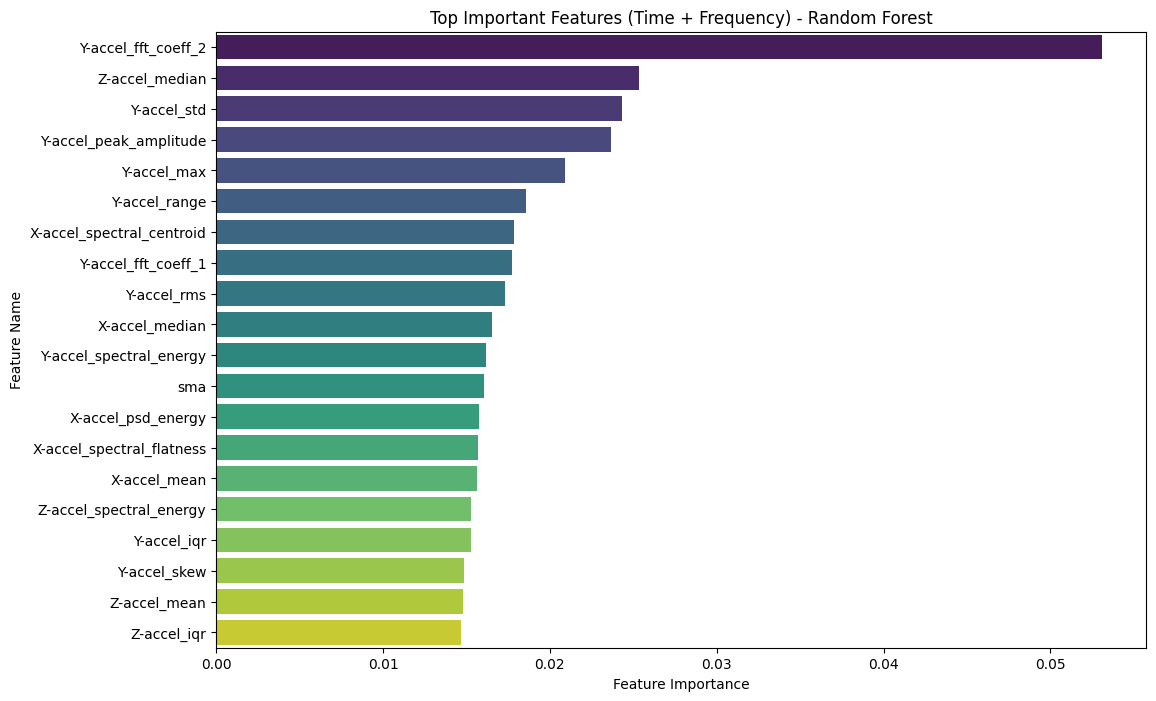

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn

all_features_df = pd.concat([features_df, frequency_df], axis=1)
labels = dataFrame['Activity Label'].iloc[::samples_per_window][:len(all_features_df)].values

# Train a Random Forest Classifier on all features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(all_features_df, labels)

# Get feature importances using results
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the top 20 important features
N = 20
plt.figure(figsize=(12, 8))
plt.title("Top Important Features (Time + Frequency) - Random Forest")
sns.barplot(x=importances[indices[:N]], y=all_features_df.columns[indices[:N]], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

reduced_features = all_features_df.iloc[:, indices[:N]]


More feature importance means it was able to capture a stronger, distinctive pattern in the data.

Model Development


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Extract features from segments
feature_list = []
for seg in segments:
    time_features = extract_time_features(seg)
    frequency_features = extract_frequency_features(seg)
    combined_features = {**time_features, **frequency_features}
    feature_list.append(combined_features)


features_df = pd.DataFrame(feature_list)
# Prepare data for modeling
X = features_df.values

# Encode labels
label_encoder = LabelEncoder()
y = dataFrame['Activity Label'].iloc[::samples_per_window][:len(features_df)].values
y_encoded = label_encoder.fit_transform(y)

# Identify and remove infrequent classes
class_counts = pd.Series(y_encoded).value_counts()
print(class_counts)
infrequent_classes = class_counts[class_counts < 2].index
X_filtered = X[~np.isin(y_encoded, infrequent_classes)]
y_filtered = y_encoded[~np.isin(y_encoded, infrequent_classes)]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Determine a valid test size
n_classes = len(np.unique(y_filtered))
test_size = max(0.2, n_classes / len(y_filtered))  # Ensure test_size is at least 0.2 and large enough

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_filtered, test_size=test_size, random_state=42, stratify=y_filtered)

# Model training and evaluation
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}



2     4
3     3
5     2
13    2
6     2
7     2
0     1
12    1
8     1
11    1
4     1
1     1
10    1
9     1
Name: count, dtype: int64


Evaluating Decision Tree:
Accuracy: 0.1667
F1 Score: 0.0833
Precision: 0.0556
Recall: 0.1667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


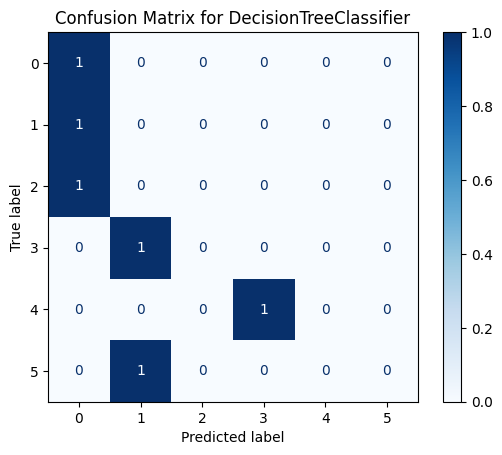

Skipping cross-validation due to insufficient samples per class. min sample:  1
----------------------------------------
Evaluating KNN:
Accuracy: 0.3333
F1 Score: 0.1778
Precision: 0.1250
Recall: 0.3333


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


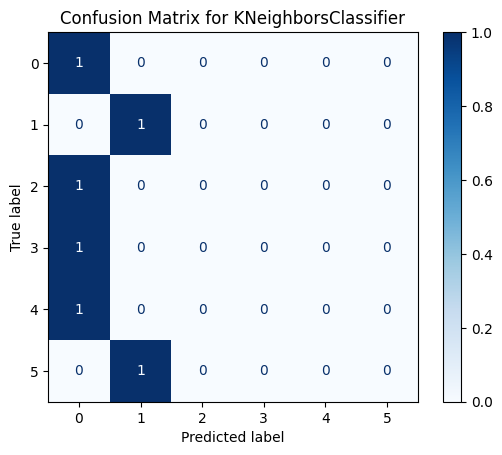

Skipping cross-validation due to insufficient samples per class. min sample:  1
----------------------------------------
Evaluating SVM:
Accuracy: 0.1667
F1 Score: 0.0476
Precision: 0.0278
Recall: 0.1667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


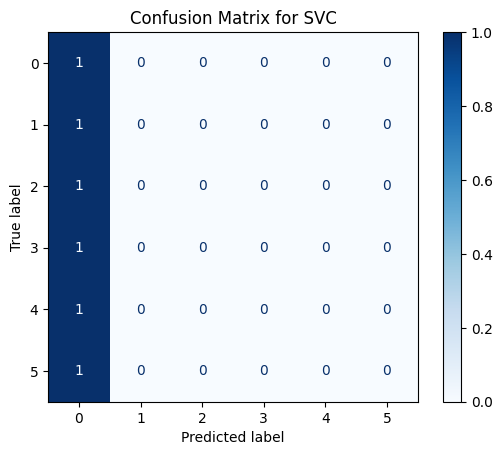

Skipping cross-validation due to insufficient samples per class. min sample:  1
----------------------------------------
Evaluating Random Forest:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.1667
F1 Score: 0.0667
Precision: 0.0417
Recall: 0.1667


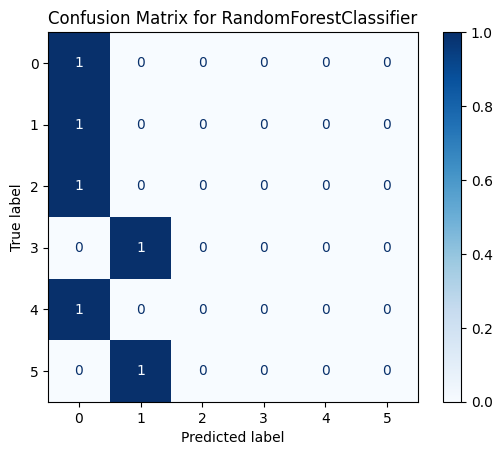

Skipping cross-validation due to insufficient samples per class. min sample:  1
----------------------------------------


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def evaluate_model(model, X_train, y_train, X_test, y_test, cv=10):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

    # Cross-validation
    # Ensure there are at least 2 samples per class in the training set
    min_samples_per_class = min(pd.Series(y_train).value_counts())
    if min_samples_per_class < 2:
        print("Skipping cross-validation due to insufficient samples per class. min sample: ", min_samples_per_class)
        return

    cv_splits = min(cv, min_samples_per_class)  # Adjust number of splits based on min class size

    if cv_splits < 2:
        print("Skipping cross-validation due to too few samples in the smallest class.")
        return

    cv_scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42), scoring='accuracy')
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean cross-validation score: {cv_scores.mean():.4f}")



for name, model in models.items():
    print(f"Evaluating {name}:")
    evaluate_model(model, X_train, y_train, X_test, y_test)
    print("-" * 40)


In [ ]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score

# Leave One Subject Out Cross Validation
def cross_val_LOSO(model, X, y, subject_labels, original_df, samples_per_window):
    print(f"Evaluating LOSO Cross-validation for {model.__class__.__name__}:")
    logo = LeaveOneGroupOut()
    cv_scores = []

    # Get subject labels corresponding to the segements
    segment_subject_labels = original_df['Subject-id'].iloc[::samples_per_window][:len(X)].values

    for train_index, test_index in logo.split(X, y, groups=segment_subject_labels):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv_scores.append(accuracy_score(y_test, y_pred))

    print(f"Mean accuracy: {np.mean(cv_scores):.4f}")
    print(f"Standard deviation: {np.std(cv_scores):.4f}")

# Leave One Episode Out Cross Validation
def cross_val_LOEO(model, X, y, episode_labels, original_df, samples_per_window):
    print(f"Evaluating LOEO Cross-validation for {model.__class__.__name__}:")
    cv_scores = []

    # Get episode labels corresponding to the segments
    segment_episode_labels = original_df['Activity Label'].iloc[::samples_per_window][:len(X)].values

    for episode in np.unique(segment_episode_labels):
        test_indices = np.where(segment_episode_labels == episode)[0]
        train_indices = np.where(segment_episode_labels != episode)[0]

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv_scores.append(accuracy_score(y_test, y_pred))

    print(f"Mean accuracy: {np.mean(cv_scores):.4f}")
    print(f"Standard deviation: {np.std(cv_scores):.4f}")

subject_labels = dataFrame['Subject-id'].values  # Using Subject_id for LOSO
episode_labels = dataFrame['Activity Label'].values  # Using Activity Label for LOEO

# Run evaluations
for name, model in models.items():
    print(f"\nEvaluating {name}:")
    # LOSO Cross-validation
    cross_val_LOSO(model, X_scaled, y_filtered, subject_labels, dataFrame, samples_per_window) # Added dataFrame and samples_per_window

    # LOEO Cross-validation
    cross_val_LOEO(model, X_scaled, y_filtered, episode_labels, dataFrame, samples_per_window) # Added dataFrame and samples_per_window

    print("-" * 40)


Evaluating Decision Tree:
Evaluating LOSO Cross-validation for DecisionTreeClassifier:
Mean accuracy: 0.2778
Standard deviation: 0.4267
Evaluating LOEO Cross-validation for DecisionTreeClassifier:
Mean accuracy: 0.1364
Standard deviation: 0.3083
----------------------------------------

Evaluating KNN:
Evaluating LOSO Cross-validation for KNeighborsClassifier:
Mean accuracy: 0.1528
Standard deviation: 0.3001
Evaluating LOEO Cross-validation for KNeighborsClassifier:
Mean accuracy: 0.2273
Standard deviation: 0.3910
----------------------------------------

Evaluating SVM:
Evaluating LOSO Cross-validation for SVC:
Mean accuracy: 0.1250
Standard deviation: 0.2976
Evaluating LOEO Cross-validation for SVC:
Mean accuracy: 0.2273
Standard deviation: 0.3910
----------------------------------------

Evaluating Random Forest:
Evaluating LOSO Cross-validation for RandomForestClassifier:
Mean accuracy: 0.1250
Standard deviation: 0.2976
Evaluating LOEO Cross-validation for RandomForestClassifier:


Key Takeaways:


*   The overall general performance demonstrated a difficulty for all the models to achieve high accuracy when evaluated with LOSO and LOEO, could mean the dataset is challenging or the model is not suited for this dataset

*   LOSO vs LOEO
  *   LOEO show better performance than LOSO
  *   Model may find it easier to generalize across same subject different activites rather than different subjects
  *   Random forest showed most promise in accuracy with 36.36%




# **CONCLUSION**


**Key Findings**

1. Efficient Data Loading and Preprocessing

2. High-Frequency Sensor Data

3. Windowing for Time Series Analysis

4. Comprehensive Feature Extraction

5. Preparation for Frequency-Domain Analysis

**Lessons Learnt**

1. Data Type Optimization is Crucial

2. High Sampling Rates Require Careful Handling

3. Windowing Strategy Impacts Feature Quality

4. Rich Feature Sets Enhance Modeling Potential

5. Modular Code Structure Facilitates Expansion

6. Data Quality and Consistency Checks are Important

**Potential Improvements**

1. Edge-Based Data Processing and Compression

2. Advanced Feature Extraction Using Deep Learning

3. Energy-Efficient and Distributed Query Processing

4. Leveraging Semi-Supervised and Attention-Based Learning

**Future Research Directions**

1. Real-Time, On-Device Analytics

2. Multi-Modal and Context-Aware Sensing

3. Privacy-Preserving Sensor Data Processing

4. Benchmarking and Dataset Expansion

5. Adaptive and Transferable Models


